<figure style="margin-left: 20px; margin-right: 20px;">
  <img src="../../figures/logo-esi-sba.png" width="256" height="256" align="right" alt="Logo">
</figure>

# Email spam classification using semi-supervised learning techniques

*Directed by* 
- Fellah Abdnour (a.fellah@esi-sba.dz) 
- Benyamina Yacine Lazreg (yl.benyamina@esi-sba.dz) 
- Mokadem Adel Abdelkader (aa.mokadem@esi-sba.dz) 
- Benounene Abdelrahmane (a.benounene@esi-sba.dz) 

# Notebook 4: Self Learning
This notebook showcases the implementation of the self-learning technique for building a machine learning model. Self-learning, also known as self-training, is a semi-supervised learning approach where the model iteratively labels its own unlabeled data and refines its predictions.

## Outline

- [Necessary Packages](#necessary_packages)
- [Data Loading](#data_loading)
- [Comparing the different models](#comparing_the_different_models)
- [Calibration graphs & probabilities histograms](calibration_graphs_and_probability_histograms)
- [Self Learning](#self_learning)
- [Conclusion](#conclusion)
- [Save the best model](#save_the_best_model)
- [Save the figures](#save_the_figures)

<div id="necessary_packages" >
    <h3>Necessary packages</h3>
</div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import cross_validate,KFold,train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix,make_scorer,roc_curve,brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from joblib import load,dump
from imblearn.over_sampling import ADASYN,SMOTE
import warnings

In [2]:
warnings.filterwarnings("ignore")

<div id="data_loading" >
    <h3>Data Loading</h3>
</div>

In [3]:
path = os.path.join("..","..","data","clean_df.csv")
df = pd.read_csv(path, encoding="iso-8859-1")
df.fillna("",inplace=True)

In [4]:
df.columns

Index(['class', 'content', 'urls_count', 'digits_count',
       'contains_currency_symbols', 'length'],
      dtype='object')

<div id="loading_different_models" >
    <h3>Loading the different model</h3>
</div>

In [5]:
path = os.path.join("..","..","models","ssl")
os.listdir(path)

['.ipynb_checkpoints',
 'sgd.joblib',
 'dtree.joblib',
 'svm.joblib',
 'xgboost.joblib',
 'knn.joblib',
 'lr.joblib',
 'nb.joblib']

In [6]:
def load_models(path):

    models = {}
    
    files = os.listdir(path)
    files = list(filter(lambda x:x.endswith("joblib"), files))

    for file in files:
        key = file.split(".")[0]
        models[key] = load(filename=os.path.join(path,file))

    return models

In [7]:
models = load_models(path)

<div id="comparing_the_different_models" >
    <h3>Comparing the different models</h3>
</div>

In [8]:
figures = {}

In [9]:
X = df["content"]
y = df["class"]
X = X[y != -1]
y = y[y != -1]

In [10]:
def tp(y_true,y_pred):
    return np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1)

In [11]:
def fp(y_true,y_pred):
    return np.sum((y_true == 0) & (y_pred == 1)) / np.sum(y_pred == 1)

In [12]:
def fn(y_true,y_pred):
    return np.sum((y_true == 1) & (y_pred == 0)) / np.sum(y_pred == 0)

In [13]:
def tn(y_true,y_pred):
    return np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_pred == 0)

In [14]:
metrics = {
    "accuracy":make_scorer(accuracy_score),
    "f1_score":make_scorer(f1_score),
    "precision":make_scorer(precision_score),
    "recall":make_scorer(recall_score),
    "auc":make_scorer(roc_auc_score),
    "tp":make_scorer(tp),
    "fp":make_scorer(fp),
    "fn":make_scorer(fn),
    "tn":make_scorer(tn),
    "brier_score_loss":make_scorer(brier_score_loss,needs_proba=True)
}

In [15]:
def evaluate_cv(models,metrics,cv,X,y):

    df = []
    index = models.keys()
    columns = ["fit_time","score_time"]
    columns = columns + list(metrics.keys())
    
    for model in models.values():
        results = cross_validate(model, X, y, cv=cv,scoring=metrics)
        scores = []
        for score in results.values():
            scores.append(score.mean())
        df.append(scores)

    df = pd.DataFrame(data=df,index=index,columns=columns)
    return df

In [16]:
evaluation_df = evaluate_cv(models,metrics,cv=KFold(shuffle=True),X=X,y=y)

In [17]:
evaluation_df

,fit_time,score_time,accuracy,f1_score,precision,recall,auc,tp,fp,fn,tn,brier_score_loss
sgd,1.750923,0.054339,0.939653,0.891263,0.920312,0.867287,0.918479,0.920312,0.079688,0.052861,0.947139,0.048210
dtree,0.227452,0.044218,0.902068,0.835575,0.802527,0.871716,0.892715,0.802527,0.197473,0.053280,0.946720,0.093115
svm,3.518266,0.188851,0.962415,0.934921,0.925605,0.946141,0.957892,0.925605,0.074395,0.022262,0.977738,0.031802
xgboost,1.027359,0.054210,0.914973,0.860714,0.822650,0.903627,0.912097,0.822650,0.177350,0.042437,0.957563,0.097446
knn,0.423744,0.162436,0.841755,0.780211,0.650880,0.976037,0.881640,0.650880,0.349120,0.012449,0.987551,0.122533
lr,0.789821,0.122462,0.971312,0.948749,0.944635,0.954952,0.966592,0.944635,0.055365,0.017979,0.982021,0.030994
nb,0.086317,0.043419,0.968341,0.944263,0.945042,0.944183,0.960950,0.945042,0.054958,0.022003,0.977997,0.030017


In [18]:
def plot_scores_barplots(evaluation_df,subset=None):

    if subset is not None:
        evaluation_df = evaluation_df[subset]
    
    fig, axes = plt.subplots(nrows=3,ncols=3)
    fig.set_size_inches(15, 7.5)
    i = 0
    
    for row in axes:
        for cell in row:
            sns.barplot(data=evaluation_df,
                        x=evaluation_df.index,
                        y=evaluation_df.columns[i],
                        ax=cell,order=evaluation_df.index[evaluation_df[evaluation_df.columns[i]].argsort()]
            )
            i += 1

            if i == evaluation_df.columns.shape[0]:
                break

        if i == evaluation_df.columns.shape[0]:
                break   
    return fig,axes

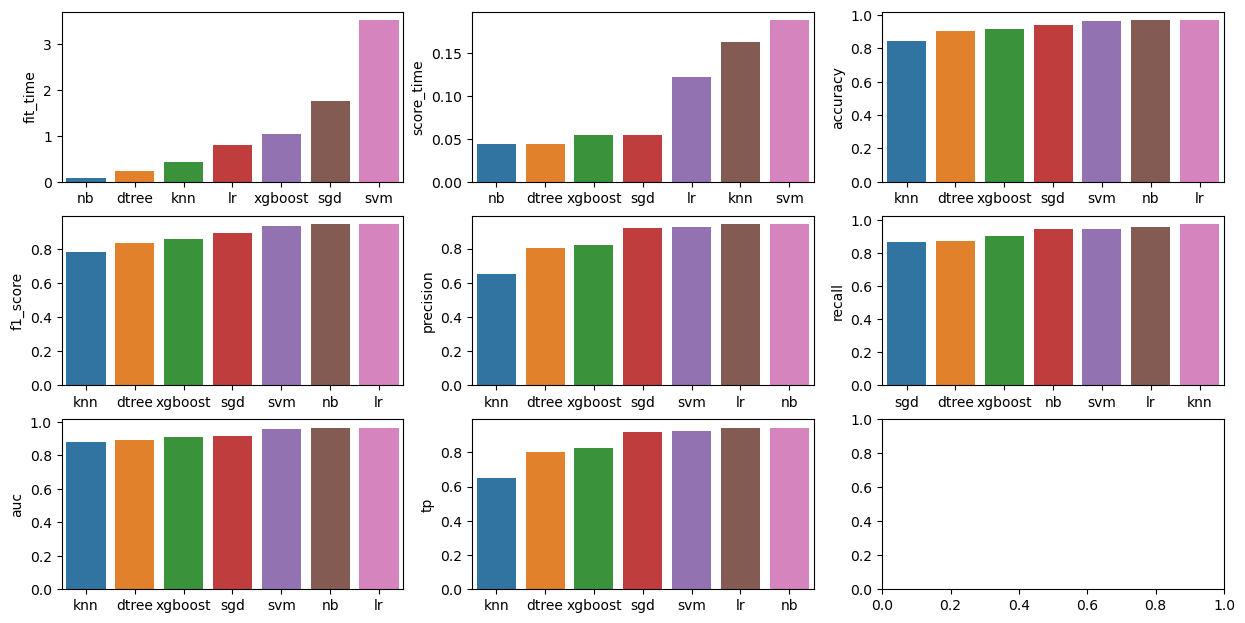

In [19]:
figures["cross_validation"] = plot_scores_barplots(evaluation_df,subset=evaluation_df.columns[:-4])

In [20]:
def plot_confusion_matrices(evaluation_df):
    fig, axes = plt.subplots(nrows = 1, ncols = 7)
    fig.set_size_inches(21, 2.6)

    for i,ax in enumerate(axes):
        row = evaluation_df.iloc[i]
        cm = np.array([
            [row["tp"],row["fp"]],
            [row["fn"],row["tn"]]
        ])
        cm = pd.DataFrame(data=cm,index=["postive","negative"],columns=["postive","negative"])

        sns.heatmap(data=cm,vmin=0,vmax=1,annot=True,ax=ax,cmap="Blues")
        ax.set_title(evaluation_df.index[i])
    return fig,axes

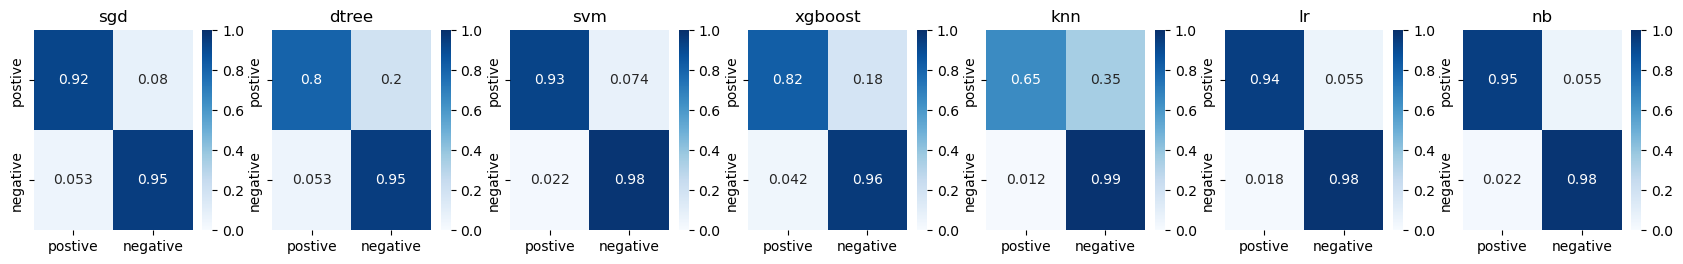

In [21]:
figures["confusion_matrices"] = plot_confusion_matrices(evaluation_df)

<div id="calibration_graphs_and_probability_histograms" >
    <h3>calibration graphs and the probabilities distribution</h3>
</div>

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [23]:
def train_models(models,X_train,y_train):
    for key in models.keys():
        models[key] = models[key].fit(X_train,y_train)

In [24]:
train_models(models, X_train,y_train)

In [25]:
def plot_calibration_graphs(model,X_test,y_test):

    fig, axes = plt.subplots(nrows = 1,ncols = 2)
    fig.set_size_inches(10,5)

    display = CalibrationDisplay.from_estimator(
        model,
        X_test,
        y_test,
        n_bins=10,
        name=model["estimator"].__class__.__name__,
        color="red",
        marker="^",
        ax=axes[0],
        ref_line=True
    )

    sns.histplot(x=display.y_prob,ax=axes[1],bins=30,label=f"brier score loss {brier_score_loss(y_test,display.y_prob):.3f}")

    axes[1].legend(loc="upper right")

    return fig,axes

- SGDClassifier : 

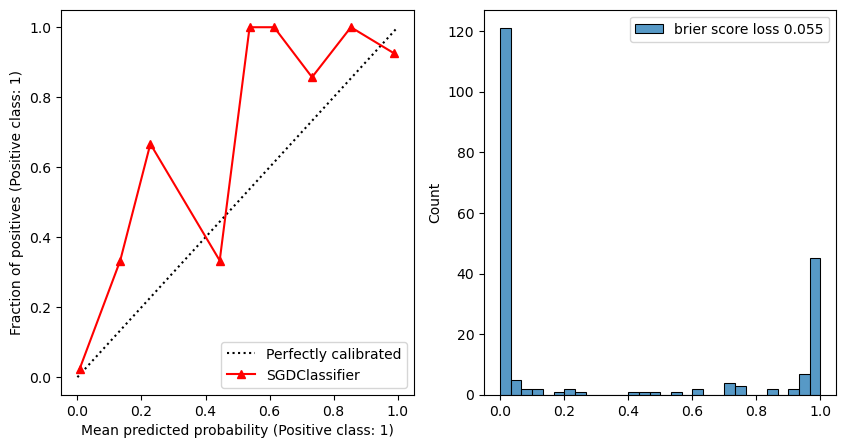

In [26]:
figures["sgd_calib"] = plot_calibration_graphs(models["sgd"],X_test,y_test)

- Logestic Regression : 

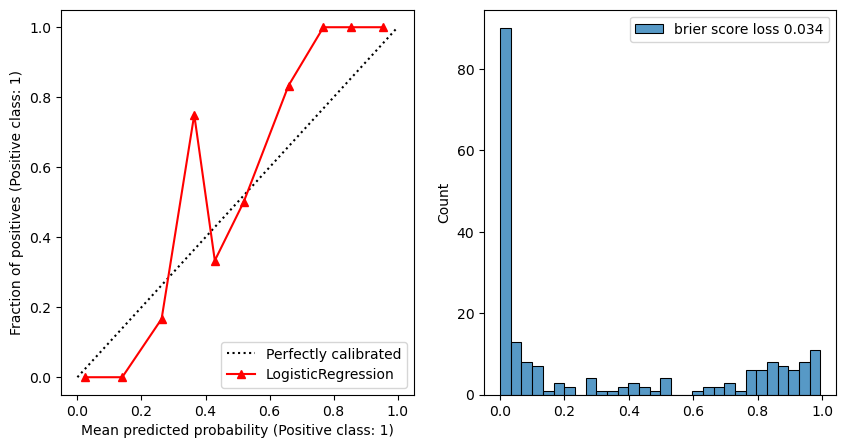

In [27]:
figures["lr_calib"] = plot_calibration_graphs(models["lr"],X_test,y_test)

- Naive Bayes

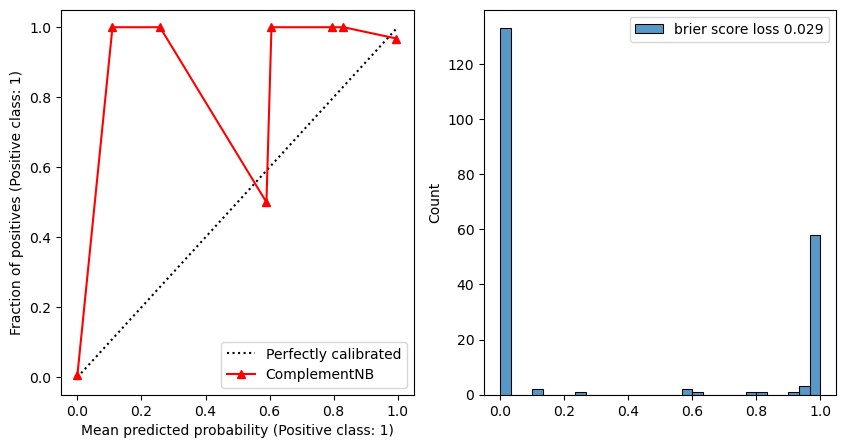

In [28]:
figures["nb_calib"] = plot_calibration_graphs(models["nb"],X_test,y_test)

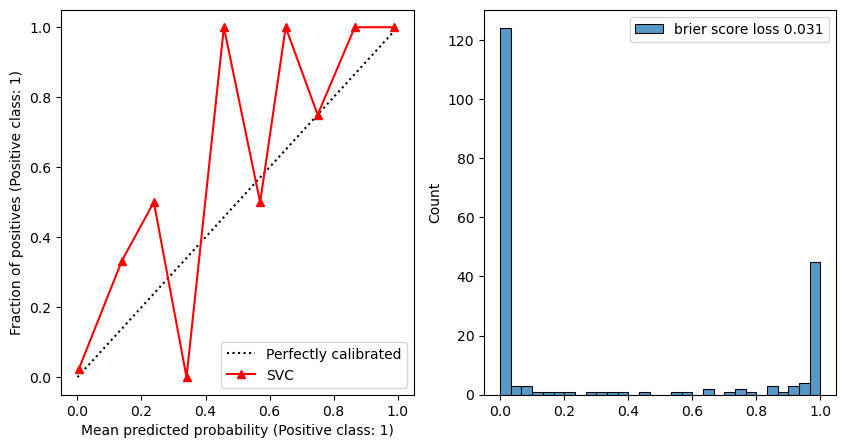

In [29]:
figures["svm_calib"] = plot_calibration_graphs(models["svm"],X_test,y_test)

- Decision Tree

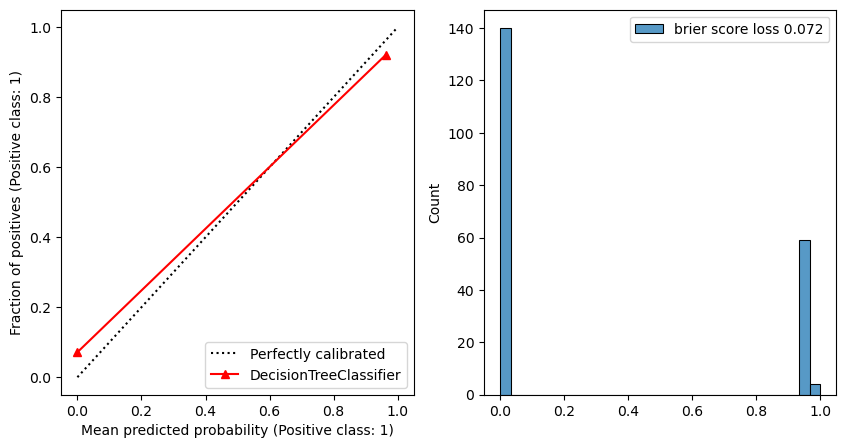

In [30]:
figures["dtree_calib"] = plot_calibration_graphs(models["dtree"],X_test,y_test)

- XGBoost

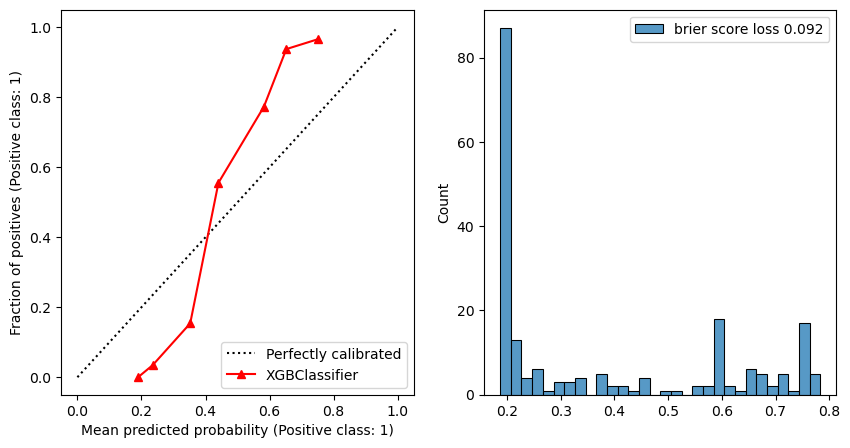

In [31]:
figures["xgboost_calib"] = plot_calibration_graphs(models["xgboost"],X_test,y_test)

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Mean predicted probability (Positive class: 1)', ylabel='Fraction of positives (Positive class: 1)'>,
        <Axes: ylabel='Count'>], dtype=object))

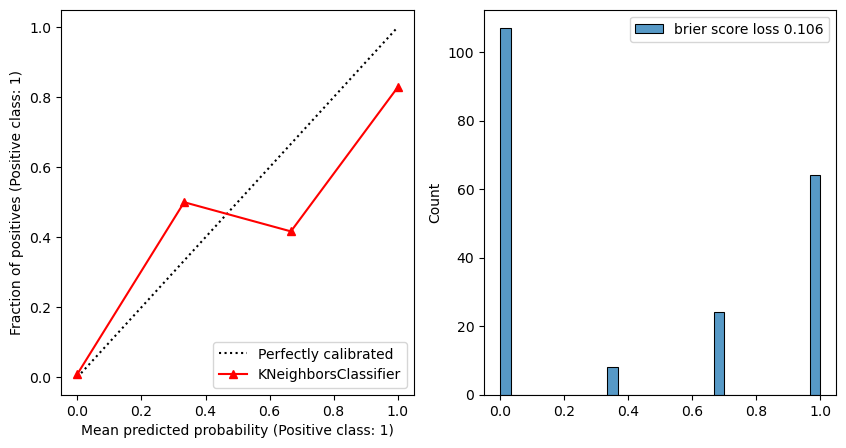

In [32]:
plot_calibration_graphs(models["knn"],X_test,y_test)

<div id="self_learning" >
    <h3>Self learning</h3>
</div>

- we will consider three models : Naive Bayes,LogisticRegression and SGDClassifier.
- We will split the data into tow part a training set that contains labled and unlabled data and a test set that contains a portion of the originally labled examples.

In [33]:
X = df["content"]
y = df["class"]

In [34]:
X_labled = X[y != -1]
y_labled = y[y != -1]

In [35]:
X_unlabled = X[y == -1]
y_unlabled = y[y == -1]

In [36]:
train_idx,test_idx = train_test_split(X_labled.index,test_size=0.3)

In [37]:
X_train = X.loc[~df.index.isin(test_idx)]
y_train = y.loc[~df.index.isin(test_idx)]
X_test = X.loc[df.index.isin(test_idx)]
y_test = y.loc[df.index.isin(test_idx)]

In [38]:
st_models = {}

In [39]:
st_models["st_sgd"] = Pipeline(steps=[
    ("cv",TfidfVectorizer()),
    ("scaler",MaxAbsScaler()),
    ("estimator",SelfTrainingClassifier(
        base_estimator=Pipeline(steps=[
            ("oversampling",ADASYN()),
            ("estimator",SGDClassifier(**models["sgd"]["estimator"].get_params()))]),
        threshold=0.8
    ))
])

In [40]:
st_models["st_sgd"].fit(X_train,y_train)

Pipeline(steps=[('cv', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('estimator',
                 SelfTrainingClassifier(base_estimator=Pipeline(steps=[('oversampling',
                                                                        ADASYN()),
                                                                       ('estimator',
                                                                        SGDClassifier(loss='log_loss'))]),
                                        threshold=0.8))])

In [41]:
st_models["st_nb"] = Pipeline(steps=[
    ("cv",CountVectorizer()),
    ("estimator",SelfTrainingClassifier(base_estimator=ComplementNB(**models["nb"]["estimator"].get_params()),threshold=0.8))
])

In [42]:
st_models["st_nb"].fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('estimator',
                 SelfTrainingClassifier(base_estimator=ComplementNB(),
                                        threshold=0.8))])

In [43]:
st_models["st_lr"] = Pipeline(steps=[
    ("tfidf",TfidfVectorizer()),
    ("scaler",MaxAbsScaler()),
    ("estimator",SelfTrainingClassifier(
        base_estimator=Pipeline(steps=[
            ("oversampling",SMOTE()),
            ("estimator",LogisticRegression(**models["lr"]["estimator"].get_params()))
        ]),
        threshold=0.8
    ))
])

In [44]:
st_models["st_lr"].fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('estimator',
                 SelfTrainingClassifier(base_estimator=Pipeline(steps=[('oversampling',
                                                                        SMOTE()),
                                                                       ('estimator',
                                                                        LogisticRegression())]),
                                        threshold=0.8))])

In [47]:
st_models["st_svm"] = Pipeline(steps=[
    ("tfidf",TfidfVectorizer()),
    ("scaler",MaxAbsScaler()),
    ("estimator",SelfTrainingClassifier(
        base_estimator=Pipeline(steps=[
            ("oversampling",SMOTE()),
            ("estimator",SVC(**models["svm"]["estimator"].get_params()))
        ]),
        threshold=0.8
    ))
])

In [48]:
st_models["st_svm"].fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('estimator',
                 SelfTrainingClassifier(base_estimator=Pipeline(steps=[('oversampling',
                                                                        SMOTE()),
                                                                       ('estimator',
                                                                        SVC(C=1,
                                                                            kernel='sigmoid',
                                                                            probability=True))]),
                                        threshold=0.8))])

In [56]:
def validate(models,metrics,X_test,y_test):
    result = []
    i = 0
    for model in models.values():
        y_hat = model.predict(X_test)
        scores = []
        for metric in metrics:
            score = metric(y_test,y_hat)
            scores.append(score)
        result.append(scores)
    columns = [metric.__name__ for metric in metrics]
    return pd.DataFrame(data=result,columns=columns,index=models.keys())

In [57]:
evaluation_df = validate(st_models,[accuracy_score,recall_score,f1_score,precision_score],X_test,y_test)

In [58]:
evaluation_df

,accuracy_score,recall_score,f1_score,precision_score
st_sgd,0.976974,0.936842,0.962162,0.988889
st_nb,0.976974,0.957895,0.962963,0.968085
st_lr,0.980263,0.947368,0.967742,0.989011
st_svm,0.950658,0.863158,0.916201,0.976190


<div id="conclusion" >
    <h3>Conclusion</h3>
</div>

- SVM performance decreased
- Other models performance has imporoved.

<div id="save_the_best_model" >
    <h3>Save the best model</h3>
</div>

In [59]:
model = st_models[evaluation_df.index[evaluation_df["f1_score"].argmax()]]
dump(value = model,filename=os.path.join("..","..","models", "st.joblib"))

['../../models/st.joblib']

<div id="save_the_figures" >
    <h3>Save the figures</h3>
</div>

In [60]:
def save_figures(figures,to):
    for key,(fig,_) in figures.items():
        fig.savefig(fname=os.path.join(to,f"{key}.png"))

In [61]:
save_figures(figures=figures,to=os.path.join("..","..","figures"))